# Imports e carregamentos

In [2]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

### Treinando Rede para cada liga baseado em busca aleatória de parâmetro

In [4]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)



Treinando modelo para a liga: South America - Copa Libertadores
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Epoch 1/300
22/22 [==============================] - 2s 15ms/step - loss: 0.7816 - accuracy: 0.4993 - val_loss: 0.7574 - val_accuracy: 0.5413 - lr: 6.7444e-04
Epoch 2/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7620 - accuracy: 0.5570 - val_loss: 0.7478 - val_accuracy: 0.5869 - lr: 6.7444e-04
Epoch 3/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7560 - accuracy: 0.5420 - val_loss: 0.7410 - val_accuracy: 0.6182 - lr: 6.7444e-04
Epoch 4/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7475 - accuracy: 0.5819 - val_loss: 0.7365 - val_accuracy: 0.5812 - lr: 6.7444e-04
Epoch 5/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7424 - accuracy: 0.5691 - val_loss: 0.7258 - val_accuracy: 0.6125 - lr: 6.7444e-04
Epoch 6/300
22/22 [==============================] - 0s 4ms/step - loss: 0.7293 - accuracy: 0.5905 - val_loss: 0.7230 - val_accuracy: 0.5954 - lr: 6.7444e-04
Epoch 7/300
22/22 [==============================] 

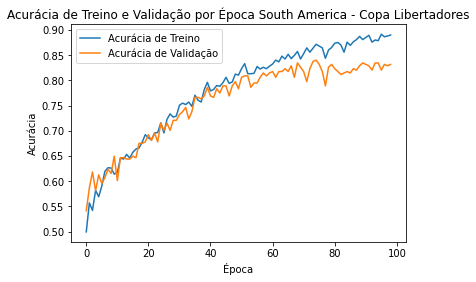

Treinando modelo para a liga: Brazil - Paulista A1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
11/11 [==============================] - 1s 25ms/step - loss: 0.7716 - accuracy: 0.4804 - val_loss: 0.7231 - val_accuracy: 0.5491 - lr: 6.1799e-04
Epoch 2/300
11/11 [==============================] - 0s 6ms/step - loss: 0.7401 - accuracy: 0.5399 - val_loss: 0.7211 - val_accuracy: 0.5665 - lr: 6.1799e-04
Epoch 3/300
11/11 [==============================] - 0s 6ms/step - loss: 0.7342 - accuracy: 0.5370 - val_loss: 0.7141 - val_accuracy: 0.5954 - lr: 6.1799e-04
Epoch 4/300
11/11 [==============================] - 0s 6ms/step - loss: 0.7267 - accuracy: 0.5776 - val_loss: 0.7110 - val_accuracy: 0.6012 - lr: 6.1799e-04
Epoch 5/300
11/11 [==============================] - 0s 6ms/step - loss: 0.7215 - accuracy: 0.5951 - val_loss: 0.7094 - val_accuracy: 0.6069 - lr: 6.1799e-04
Epoch 6/

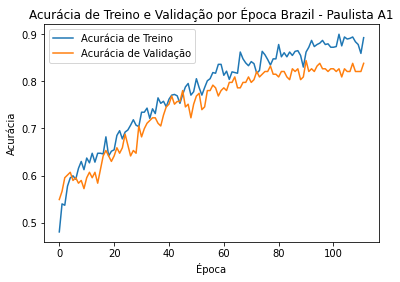

Treinando modelo para a liga: Asia - AFC Champions League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
8/8 [==============================] - 1s 36ms/step - loss: 0.9287 - accuracy: 0.5187 - val_loss: 0.8980 - val_accuracy: 0.5469 - lr: 0.0041
Epoch 2/300
8/8 [==============================] - 0s 8ms/step - loss: 0.8935 - accuracy: 0.5599 - val_loss: 0.8713 - val_accuracy: 0.5312 - lr: 0.0041
Epoch 3/300
8/8 [==============================] - 0s 9ms/step - loss: 0.8759 - accuracy: 0.5796 - val_loss: 0.8697 - val_accuracy: 0.5547 - lr: 0.0041
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 0.8312 - accuracy: 0.6228 - val_loss: 0.8483 - val_accuracy: 0.5625 - lr: 0.0041
Epoch 5/300
8/8 [==============================] - 0s 8ms/step - loss: 0.8004 - accuracy: 0.6582 - val_loss: 0.8426 - val_accuracy: 0.5938 - lr: 0.0041
Epoch 6/300
8/8 [==============

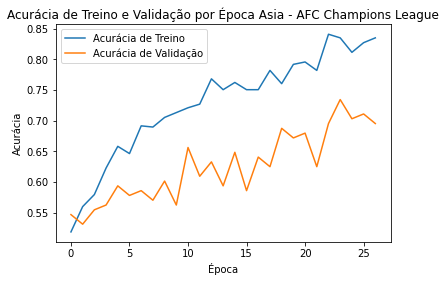

Treinando modelo para a liga: Japan - J-League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [5]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from keras.metrics import Precision, Recall
from keras.regularizers import l1_l2
from keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scipy.stats import loguniform

# Função para criar o modelo Keras com as novas sugestões aplicadas
def create_model(learning_rate=0.001, l2_rate=0.0001, dropout_rate=0.4):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Use a learning rate schedule
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

for league in df['league'].unique():
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual

    league_data = df[df['league'] == league]

    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result'].values  # Garantindo que y é um array numpy

    # Criando e ajustando o preprocessador
    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)
    print("Dados transformados pelo preprocessador.")

    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
    print("Dados divididos em conjuntos de treino e teste.")

    # Callback de EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Callback de ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

    # Ajustando os hiperparâmetros para a pesquisa
    param_dist = {
        'learning_rate': loguniform(1e-4, 1e-2).rvs(1000),  # Exploring a wider range of learning rates
        'l2_rate': loguniform(1e-5, 1e-3).rvs(1000),        # Adjusting L2 regularization rate
        'dropout_rate': [0.3, 0.4, 0.5]                     # Testing different dropout rates
    }

    model = KerasClassifier(build_fn=create_model, epochs=300, callbacks=[early_stop, reduce_lr], batch_size=32, verbose=1, learning_rate=param_dist['l2_rate'], l2_rate=param_dist['l2_rate'], dropout_rate=param_dist['dropout_rate'])
    # Criando o RandomizedSearchCV com a nova distribuição de hiperparâmetros
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Executando a pesquisa aleatória
    random_search_results = random_search.fit(
        X_train,
        y_train,
        callbacks=[early_stop, reduce_lr],
        validation_data=(X_test, y_test)  
    )

    # Imprimindo os melhores resultados
    print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

    # Plote as métricas de treino e validação com o melhor modelo
    best_model = random_search_results.best_estimator_

    # Prever as probabilidades para o conjunto de teste
    y_probs = best_model.predict(X_test)
    class_names = ['Classe 0', 'Classe 1']
    # Imprimir o relatório de classificação
    print(classification_report(y_test, y_probs, target_names=class_names))

    plt.plot(best_model.history_['accuracy'], label='Acurácia de Treino')
    plt.plot(best_model.history_['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia de Treino e Validação por Época {league}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

    best_model.model_.save(f'../models/model_redeht_{league}.h5')

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Prever as probabilidades para o conjunto de teste
# y_probs = model.predict(X_test)

# # Inicialize o valor do threshold que você quer testar, por exemplo:
# thresholds = np.arange(0.1, 0.9, 0.1)

# # Para cada threshold, calcule e imprima as métricas
# for thresh in thresholds:
#     # Converta probabilidades em previsões binárias com base no threshold
#     y_pred = (y_probs >= thresh).astype(int)
    
#     # Calcule as métricas
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Imprima as métricas
#     print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# # Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso
